In [67]:
import numpy as np
import matplotlib.pyplot as plt

def split_data_numpy(X_all, t_all, test_size_ratio, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    N_total = X_all.shape[0]
    indices = np.arange(N_total)
    np.random.shuffle(indices)
    N_test = int(N_total * test_size_ratio)
    test_indices = indices[:N_test]
    train_indices = indices[N_test:]
    X_train, X_test = X_all[train_indices], X_all[test_indices]
    t_train, t_test = t_all[train_indices], t_all[test_indices]
    return X_train, X_test, t_train, t_test

def mean_squared_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.mean((y_true - y_pred) ** 2)


def get_kernel(x, M, kernelType='polynomial', **kwargs):
    x = np.asarray(x).reshape(-1, 1)
    if kernelType == 'gaussian':
        centers = kwargs.get('centers')
        sigma = kwargs.get('sigma', 0.1)
        if centers is None:
            raise ValueError("No centers provided")
        centers = np.asarray(centers).reshape(1, -1)
        return np.exp(- (x - centers) ** 2 / (2 * sigma ** 2))

    elif kernelType == 'polynomial':
        return np.hstack([x ** i for i in range(M + 1)])

    elif kernelType == 'sigmoid':
        return np.hstack([np.tanh(a * x + b + i) for i in range(M + 1)])

    else: 
        raise ValueError("Kernel not found")

def KernelRegressionFit(X_train,t_train,kernelType,M,lamda, **kwargs): #(training data, training targets, type of kernel, regularization coefficient)
    #kernelType : {Polynomial,Gaussian,Sigmoid}
    #print(X_train.shape)
    X = []
    if kernelType == 'gaussian':
    #Use Gaussian kernel to transform the data
        phi = get_kernel(X_train, M, kernelType='gaussian', centers=centers, sigma=sigma)
        
    elif kernelType == 'polynomial':
        phi = get_kernel(X_train,M,'polynomial')

    elif kernelType == 'sigmoid':
        phi = get_kernel(X_train,M,'sigmoid',a=a,b=b)

    I = np.eye(phi.shape[1])
    w_opt = np.linalg.inv(phi.T @ phi + lamda * I) @ phi.T @ t_train

    return w_opt

def KernelRegressionPred_Error(w_est, X_train, Y_train, X_test, Y_test, kernelType, M, **kwargs):
    # Construct design matrices
    Phi_train = get_kernel(X_train, M, kernelType=kernelType, **kwargs)
    Phi_test = get_kernel(X_test, M, kernelType=kernelType, **kwargs)

    # Predictions
    y_train_pred = Phi_train @ w_est
    y_test_pred = Phi_test @ w_est

    # Compute MSE
    train_error = mean_squared_error(Y_train, y_train_pred)
    test_error = mean_squared_error(Y_test, y_test_pred)

    return train_error, test_error


In [68]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate 100 data points in [0, 1]
x = np.linspace(0, 1, 100)

# Generate noise from N(0, 0.1)
noise = np.random.normal(0, np.sqrt(0.1), size=x.shape)

# Compute target values t_n = sin(2πx_n) + ε_n
t = np.sin(2 * np.pi * x) + noise

X_train, X_test, t_train, t_test = split_data_numpy(x,t,0.5)

kernel_types = ['polynomial', 'gaussian', 'sigmoid']

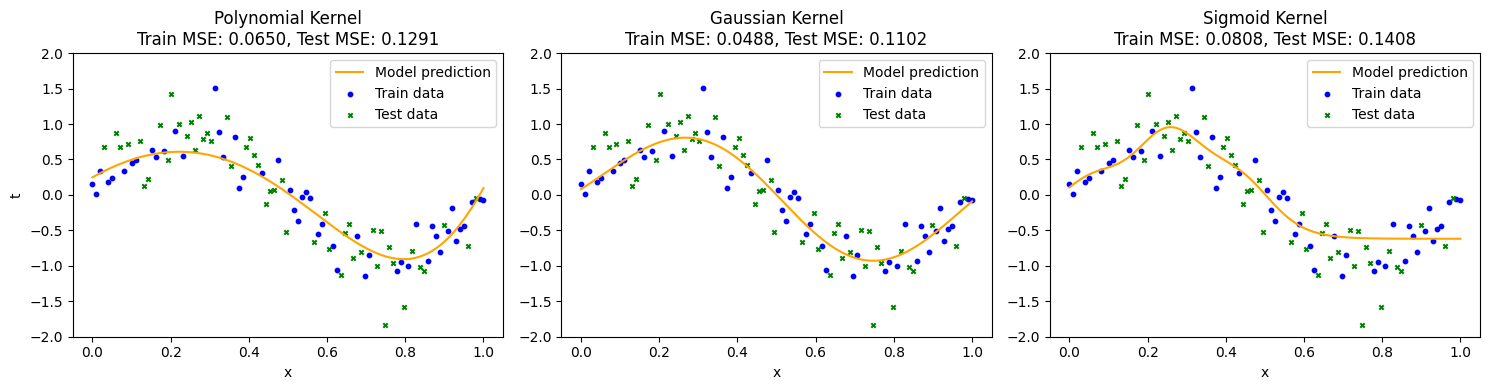

In [75]:
# Degree or number of basis functions
M = 10  
lamda = 0.01

# For Gaussian kernel
centers = np.linspace(X_train.min(), X_train.max(), M + 1)
sigma = 0.3

# For Sigmoid kernel
a = 10
b = -5

# Plot settings
x_vis = np.linspace(0, 1, 300)
plt.figure(figsize=(15, 4))
for i, kernel in enumerate(kernel_types):
    if kernel == 'polynomial':
        w_est = KernelRegressionFit(X_train, t_train, kernelType=kernel, M=M, lamda=lamda)
        Phi_vis = get_kernel(x_vis, M, kernelType=kernel)
        y_vis = Phi_vis @ w_est
        train_err, test_err = KernelRegressionPred_Error(
            w_est, X_train, t_train, X_test, t_test, kernelType=kernel, M=M
        )

    elif kernel == 'gaussian':
        w_est = KernelRegressionFit(X_train, t_train, kernelType=kernel, M=M, lamda=lamda,
                                    centers=centers, sigma=sigma)
        Phi_vis = get_kernel(x_vis, M, kernelType=kernel, centers=centers, sigma=sigma)
        y_vis = Phi_vis @ w_est
        train_err, test_err = KernelRegressionPred_Error(
            w_est, X_train, t_train, X_test, t_test,
            kernelType=kernel, M=M, centers=centers, sigma=sigma
        )

    elif kernel == 'sigmoid':
        w_est = KernelRegressionFit(X_train, t_train, kernelType=kernel, M=M, lamda=lamda,
                                    a=a, b=b)
        Phi_vis = get_kernel(x_vis, M, kernelType=kernel, a=a, b=b)
        y_vis = Phi_vis @ w_est
        train_err, test_err = KernelRegressionPred_Error(
        w_est, X_train, t_train, X_test, t_test, kernelType=kernel, M=M
        )


    # Plotting
    plt.subplot(1, 3, i + 1)
    plt.title(f'{kernel.capitalize()} Kernel\nTrain MSE: {train_err:.4f}, Test MSE: {test_err:.4f}')
    plt.plot(x_vis, y_vis, label='Model prediction', color='orange')
    plt.scatter(X_train, t_train, label='Train data', color='blue', s=10)
    plt.scatter(X_test, t_test, label='Test data', color='green', marker='x', s=10)
    plt.ylim(-2, 2)
    plt.xlabel('x')
    if i == 0:
        plt.ylabel('t')
    plt.legend()

plt.tight_layout()
plt.show()
